# Imports and Setup

In [227]:
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from IPython.display import Image
from qutip import (Qobj, about, basis, Bloch, Bloch3d, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, sigmam, sigmap, tensor, thermal_dm, sesolve)
from qutip.qip.operations import hadamard_transform as HD, rx, ry, rz
from qutip.ipynbtools import plot_animation
from scipy.optimize import curve_fit
# %matplotlib notebook
plt.rc('font', size=16)         # Set the default text font size
plt.rc('axes', titlesize=16)    # Set the axes title font size
plt.rc('axes', labelsize=16)    # Set the axes labels font size
plt.rc('xtick', labelsize=16)   # Set the font size for x tick labels
plt.rc('ytick', labelsize=16)   # Set the font size for y tick labels
plt.rc('legend', fontsize=18)   # Set the legend font size
plt.rc('figure', titlesize=20)  # Set the font size of the figure title
plt.rc("text", usetex=False)

#Adjusting the way to write some of the functions because I'm lazy
σx = sigmax
σy = sigmay
σz = sigmaz
I = qeye

# Hamiltonian
We will be using the Hamiltonian for a two level system in an electric field. Generically we write this as:
$$
\mathcal{H} = -(\epsilon + 2\vec{p}\cdot \vec{E}(t)\cos(t\phi) )\hat{S}^Z - 2\vec{p}\cdot \vec{E}(t)\sin (2\phi) \hat{S}^X
$$
Where we have $\epsilon = \sqrt{\Delta^2+\Delta_T^2}$ where $Delta$ is the energy asymmetry of the double well and $\Delta_T$ is the tunnelling probability between the two wells. $\phi$ defines the ratio between the all the energies in that $\tan 2\phi = \Delta_T/\Delta$, $\sin 2\phi = \Delta_T/\epsilon$, and $\cos 2\phi = \Delta/\epsilon$.

We will consider the case where we have two independent oscillating electric fields. This means that $\vec{E}(t)$ is given by $\vec{E}(t) = \vec{E}_1 \cos(\nu_1 t) + \vec{E}_2 \cos (\nu_2 t)$. This means that the full Hamiltonian is given by
$$
\mathcal{H}_2 = -\epsilon \hat{S}^Z - \sum_{i=1,2} 2\hbar \Omega_{Z,i}\cos(\nu_i t) \hat{S}^Z + 2\hbar \Omega_{X,,i}\cos(\nu_i t)\hat{S}^X
$$
where $\Omega_{z,i} = \Omega_0\cos(\theta_i)\cos(2\phi)$, $\Omega_{x.i}=\Omega\cos(\theta_i)\sin(2\phi)$ and $\Omega_0$ is the bare Rabi Frequency. $\theta_i$ is the angle between the electric dipole and the $\vec{E}_i$ field for each of teh two fields. We will consider the case that the $\Omega_{Z/X,1}=\Omega_{Z/X,2}\equiv \Omega_X$ so that we can rewrite the X component of the field to be:
$$
\Omega_{X,1}\cos(\nu_1 t) + \Omega_{X,2}\cos(\nu_2 t) = \Omega_x(\cos(\nu_1 t)+\cos(\nu_2 t)) = 2\Omega_x \cos(\tilde{\nu} t)\cos(\delta\nu t) \equiv \Omega_x(t)
$$
Where we defined $\tilde{\nu}=(\nu_1+\nu_2)/2$ and $\tilde{\nu_2} = (\nu_1-\nu_2)/2$. Then we can ignore the AC Stark term (the $\Omega_{Z,i}$ terms) and we apply the Rotating Wave Approximation we get the final Hamiltonian that we will use:

$$ \mathcal{H}'_2 = -(\epsilon - \hbar\tilde{\nu})\hat{S}^Z -2\hbar\Omega_X\cos(\delta\nu t)\hat{S}^X$$

## Define Hamiltonian

In [2]:
def H2(t: float, args: dict):

    ϵ = args["eps"]
    νp = args["vp"]
    Ωx = args["omegaX"]
    δν = args["dv"]
    return -(ϵ-νp)*Sz - 2*Ωx*np.cos(δν*t)*Sx

## Constants

In [21]:
δν = 0.05
νp = 5
Ωx = 0.0633
ϵ = 5
Sx = σx()/2
Sy = σy()/2
Sz = σz()/2

## First Attempt Just Using the SE Solver

In [22]:
ψ0 = basis(2,0)
times = np.linspace(0,250,2500)
result = sesolve(H2,ψ0, times, e_ops=[], args=dict(eps=ϵ, vp=νp, omegaX=Ωx, dv=δν), progress_bar=True)

10.0%. Run time:   1.28s. Est. time left: 00:00:00:11
20.0%. Run time:   2.38s. Est. time left: 00:00:00:09
30.0%. Run time:   3.53s. Est. time left: 00:00:00:08
40.0%. Run time:   4.75s. Est. time left: 00:00:00:07
50.0%. Run time:   5.93s. Est. time left: 00:00:00:05
60.0%. Run time:   7.15s. Est. time left: 00:00:00:04
70.0%. Run time:   8.39s. Est. time left: 00:00:00:03
80.0%. Run time:   9.50s. Est. time left: 00:00:00:02
90.0%. Run time:  11.06s. Est. time left: 00:00:00:01
Total run time:  12.65s


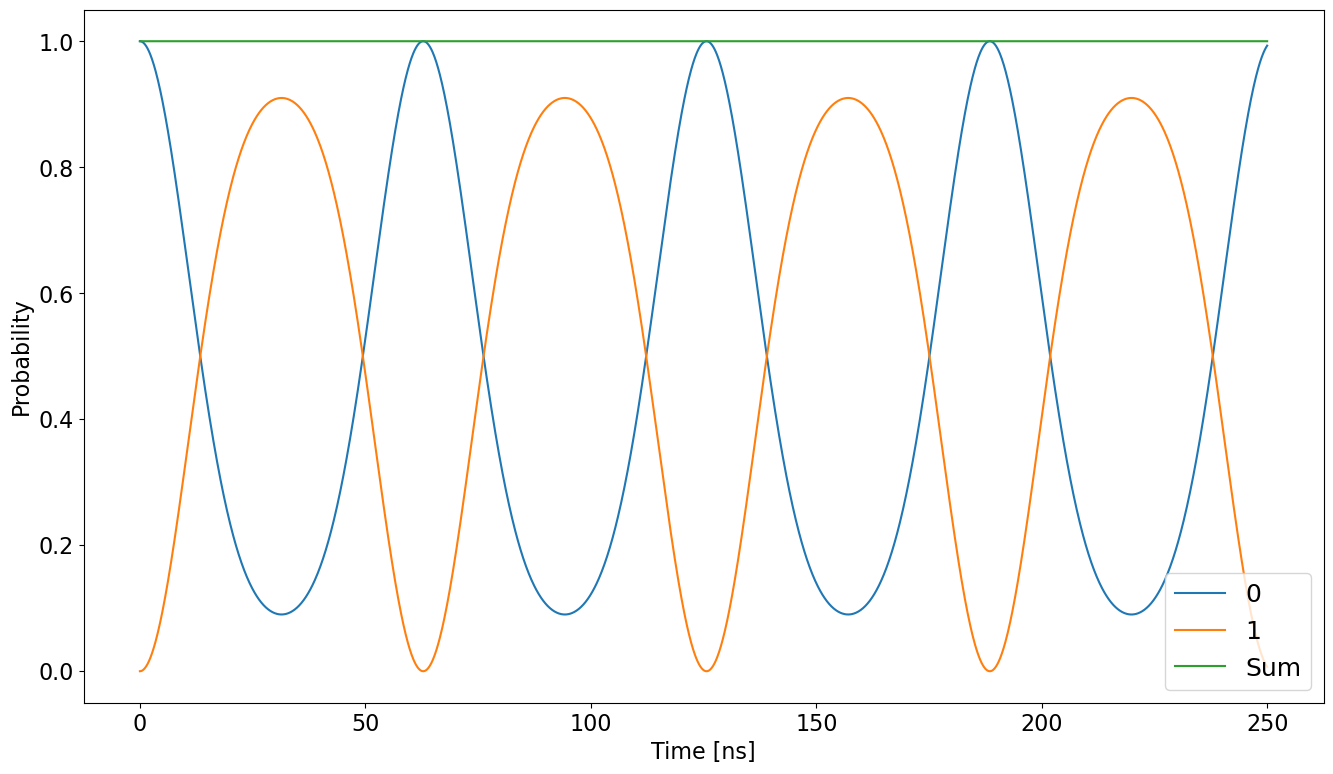

In [23]:
fig, ax = plt.subplots(figsize=(16,9))
probs = np.abs(result.states) ** 2
ax.plot(result.times, probs[:,0], label="0")
ax.plot(result.times, probs[:,1], label="1")
ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

In [6]:
def sineSqFit(t,A,v,ϕ, DC):
    return A*(np.sin(v*t+ϕ))**2+DC

In [7]:
pop, pcov = curve_fit(sineSqFit, result.times, probs[:,1].flatten(), [1, 0.1, 0, 0 ])
print(pop)
print("Hello World")

[ 0.15773897  0.10158958 -0.71161677  0.41965077]
Hello World


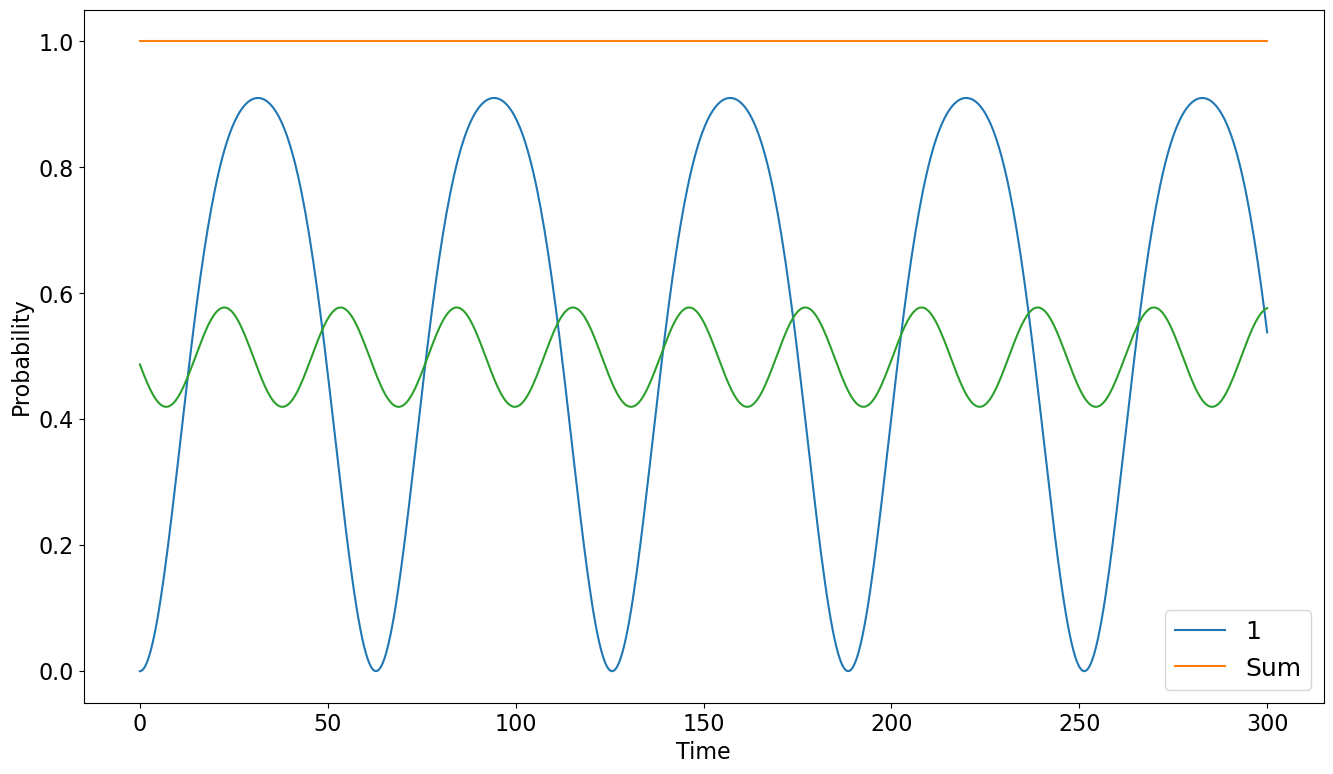

In [13]:
fig, ax = plt.subplots(figsize=(16,9))
probs = np.abs(result.states) ** 2
# ax.plot(result.times, probs[:,0], label="0")
ax.plot(result.times, probs[:,1].flatten(), label="1")
ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")
ax.plot(result.times, sineSqFit(result.times, *pop))
# ax.plot(result.times, sineSqFit(result.times, *[1, 0.1, 0, 0 ]))
ax.set_xlabel("Time")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

In [20]:
print(pop)

In [66]:
def plot_setup(result):

    fig = plt.figure(figsize=(8, 8))
    axes = Axes3D(fig, azim=-40, elev=30)

    return fig, axes

In [75]:
sphere = None


def plot_result(result, n, fig=None, axes=None):

    global sphere

    if fig is None or axes is None:
        fig, axes = plot_setup(result)

    if not sphere:
        sphere = Bloch(axes=axes)
        sphere.vector_color = ["r"]

    sphere.clear()
    sphere.add_vectors([result.expect[0][n]])
                        # result.expect[1][n],
                        # result.expect[2][n]])
    sphere.add_points(
        [
            result.expect[0][: n + 1],
            # result.expect[1][: n + 1],
            # result.expect[2][: n + 1],
        ],
        meth="l",
    )
    sphere.make_sphere()

    return axes.artists

IndexError: index 1 is out of bounds for axis 0 with size 1

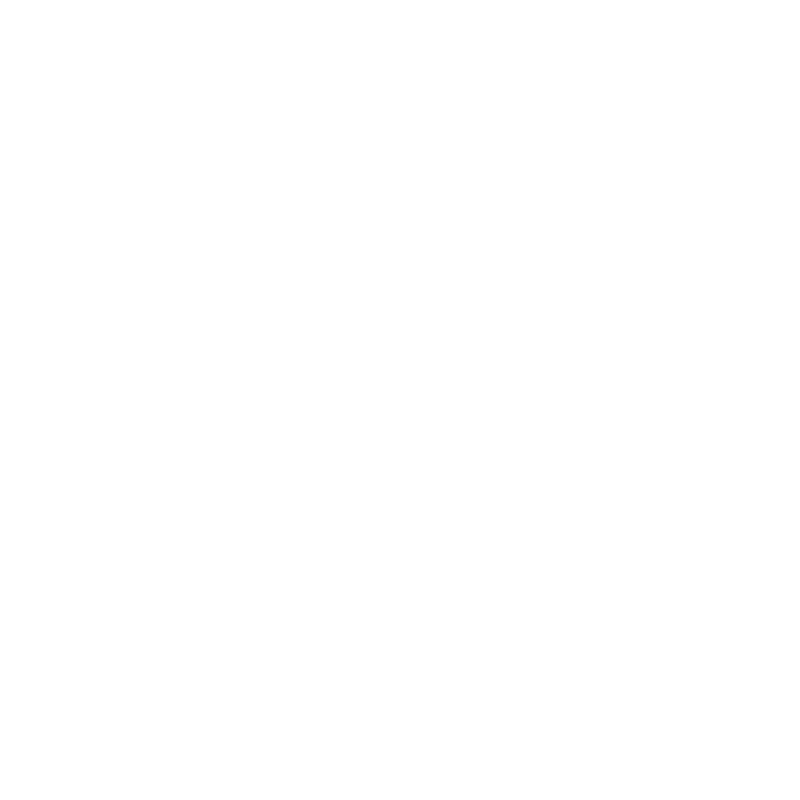

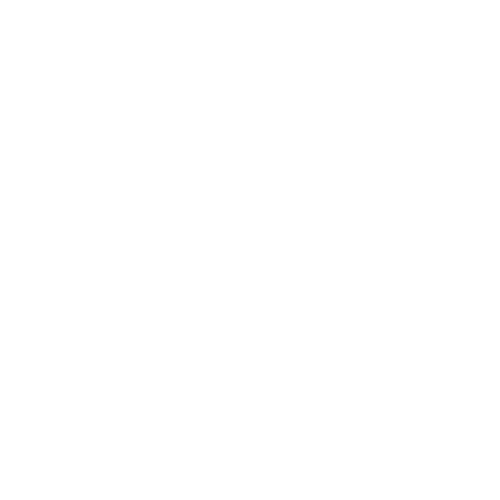

In [76]:
plot_animation(plot_setup, plot_result, result, writer="ffmpeg", codec=None)

## Trying Bloch Sphere Visualization

In [14]:
b = Bloch()
b.add_states(result.states[0])
b.add_states(result.states[4])
print(b.fig)
print(b.axes)
b.render()

None
None


In [20]:
sphere = Bloch()
sphere.render()
print(sphere.axes, sphere.fig)

def animate(i):
    sphere.clear()
    sphere.add_states(result.states[i])
    sphere.render()
    return sphere.axes

def init():
    sphere.vector_color = ["r"]
    return sphere.axes

# sphere.clear()
# sphere.add_states(result.states[0])
# sphere.render()
ani = animation.FuncAnimation(sphere.fig, animate, len(result.times), init_func=init, blit=False, repeat=False)
writer = animation.PillowWriter(fps=30, bitrate=1800)
ani.save('bloch_sphere3.gif', writer=writer)

Axes3D(0,0;1x1) Figure(500x500)


In [102]:
dir(b)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_arcs',
 '_ext_fig',
 '_is_inline_backend',
 '_lines',
 '_repr_png_',
 '_repr_svg_',
 'add_annotation',
 'add_arc',
 'add_line',
 'add_points',
 'add_states',
 'add_vectors',
 'annotations',
 'axes',
 'background',
 'clear',
 'fig',
 'figsize',
 'font_color',
 'font_size',
 'frame_alpha',
 'frame_color',
 'frame_width',
 'make_sphere',
 'plot_annotations',
 'plot_arcs',
 'plot_axes',
 'plot_axes_labels',
 'plot_back',
 'plot_front',
 'plot_lines',
 'plot_points',
 'plot_vectors',
 'point_alpha',
 'point_color',
 'point_marker',
 'point_size',
 'point_style',
 'points',
 'render',
 'run_from_ipython',
 's

In [110]:
b.render()

# $T_1$ Simulation

In [213]:
H = Qobj([[1,0],[0,1]])
g = 0.01
c_ops = [np.sqrt(g)*sigmap()]
psi0 = basis(2,1)
maxTime = 800
times = np.linspace(0,maxTime, 2*maxTime)
Mresults = mesolve(H, psi0, times, c_ops, progress_bar=True)

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
30.0%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.02s. Est. time left: 00:00:00:00
50.0%. Run time:   0.03s. Est. time left: 00:00:00:00
60.0%. Run time:   0.03s. Est. time left: 00:00:00:00
70.0%. Run time:   0.04s. Est. time left: 00:00:00:00
80.0%. Run time:   0.05s. Est. time left: 00:00:00:00
90.0%. Run time:   0.05s. Est. time left: 00:00:00:00
Total run time:   0.06s


In [214]:
Mresults

Result object with mesolve data.
--------------------------------
states = True
num_collapse = 1

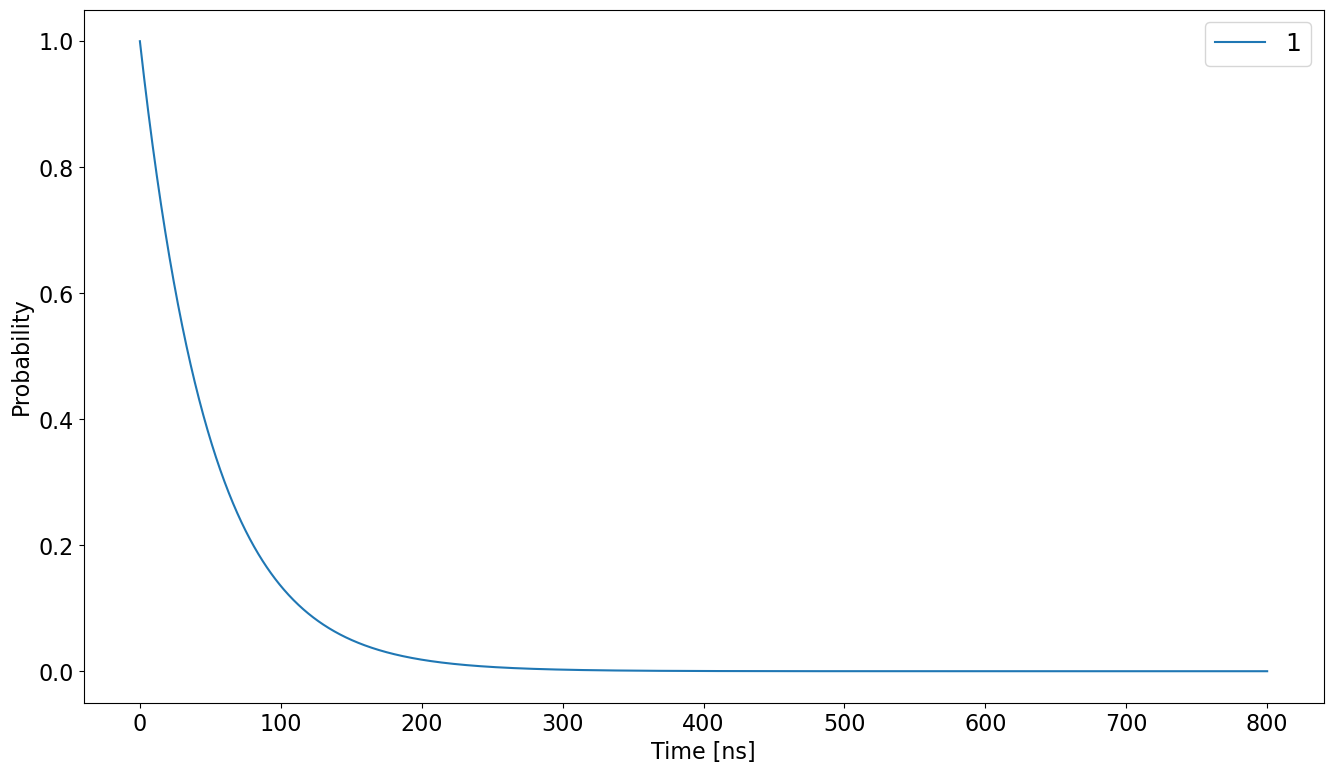

In [215]:
fig, ax = plt.subplots(figsize=(16,9))
probs = np.abs(Mresults.states) ** 2
# ax.plot(result.times, probs[:,0], label="0")
ax.plot(Mresults.times, probs[:,1,1], label="1")
# ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

In [202]:
def expFit(t, A, d,DC):
    return A*np.exp(d*t)+DC

C:\Users\Zak\Anaconda3\envs\TLS\Lib\site-packages\numpy\lib\function_base.py:626: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


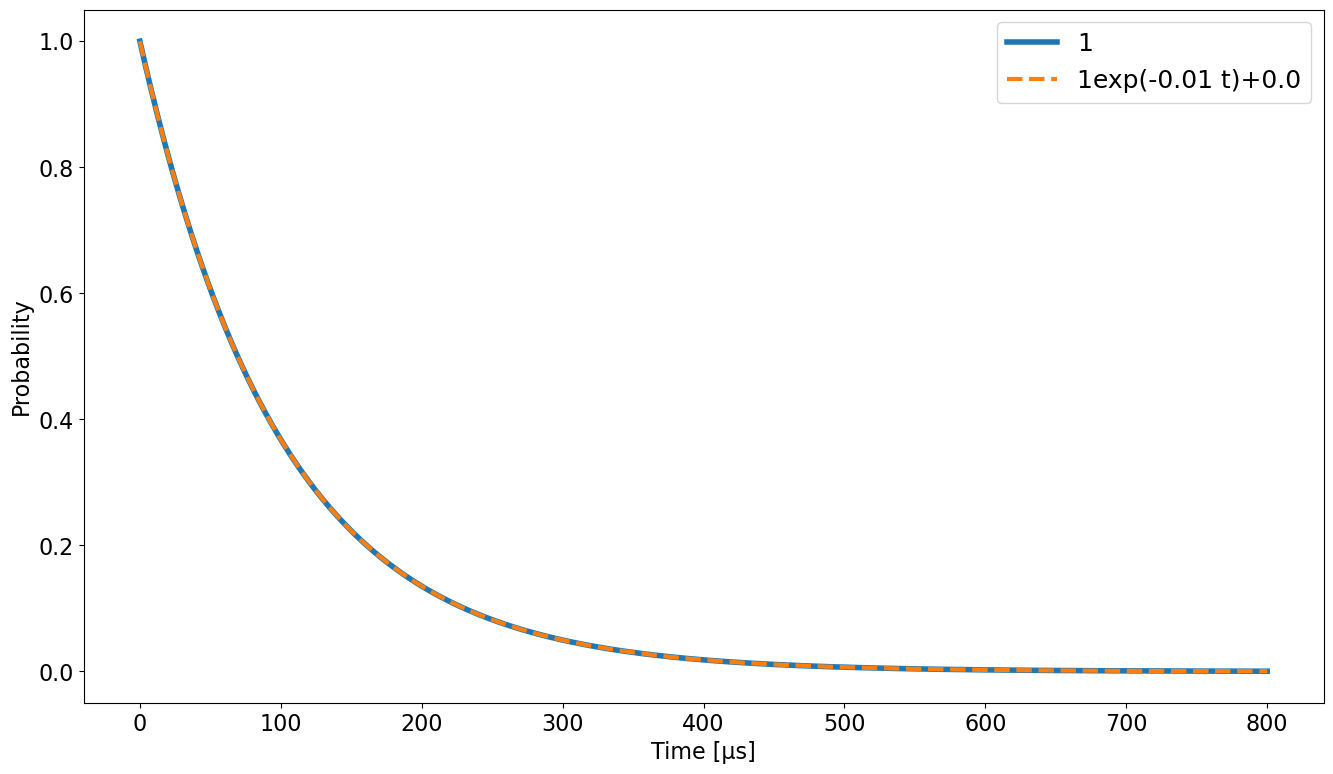

In [216]:

fig, ax = plt.subplots(figsize=(16,9))
# probs = np.abs(Mresults.states) ** 2
m = Qobj([[0,0],[0,1]])*Mresults.states
probs=[]
for state in m:
    probs.append(state[0,0]+state[1,1])
# ax.plot(result.times, probs[:,0], label="0")
pop, pcov = curve_fit(expFit, Mresults.times, probs, [1,-0.01,0.25])
ax.plot(Mresults.times, probs, label="1", linewidth=4)
ax.plot(Mresults.times, expFit(Mresults.times, *pop), "--", label=f"{pop[0]:0.0f}exp({pop[1]:0.2f} t)+{pop[2]:0.1f}", linewidth=3)
# ax.plot(Mresults.times, expFit(Mresults.times, *[1,-0.01,0.25]), "--")
# ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")

ax.set_xlabel("Time [μs]")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

In [204]:
print(pop)

[ 9.99999580e-01 -9.99998876e-03  5.28294517e-08]


In [205]:
expFit(0,*pop)

0.999999633292044

In [206]:
sphere = Bloch()
sphere.render()
print(sphere.axes, sphere.fig)

def animate(i):
    sphere.clear()
    sphere.add_states(Mresults.states[i])
    sphere.render()
    return sphere.axes

def init():
    sphere.vector_color = ["r"]
    return sphere.axes

# sphere.clear()
# sphere.add_states(result.states[0])
# sphere.render()
ani = animation.FuncAnimation(sphere.fig, animate, len(Mresults.times), init_func=init, blit=False, repeat=False)
writer = animation.PillowWriter(fps=30, bitrate=1800)
ani.save('T1_BlochSphere.gif', writer=writer)

Axes3D(0,0;1x1) Figure(500x500)


## $T_2$ Dephasing Time

In [240]:
H = Qobj([[0,0],[0,1]])
g = 0.1
c_ops = [np.sqrt(g)*sigmax()]
psi0 = HD()*basis(2,0)
maxTime = 100
times = np.linspace(0,maxTime, 4*maxTime)
Mresults = mesolve(H, psi0, times, c_ops, progress_bar=True)

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.01s. Est. time left: 00:00:00:00
50.0%. Run time:   0.01s. Est. time left: 00:00:00:00
60.0%. Run time:   0.01s. Est. time left: 00:00:00:00
70.0%. Run time:   0.02s. Est. time left: 00:00:00:00
80.0%. Run time:   0.02s. Est. time left: 00:00:00:00
90.0%. Run time:   0.02s. Est. time left: 00:00:00:00
Total run time:   0.02s


In [241]:
Mresults

Result object with mesolve data.
--------------------------------
states = True
num_collapse = 1

In [300]:
def dampedSineFit(t, A, d, v, ϕ, DC):
    return A*np.exp((d*t))*np.sin(v*t+ ϕ) + DC

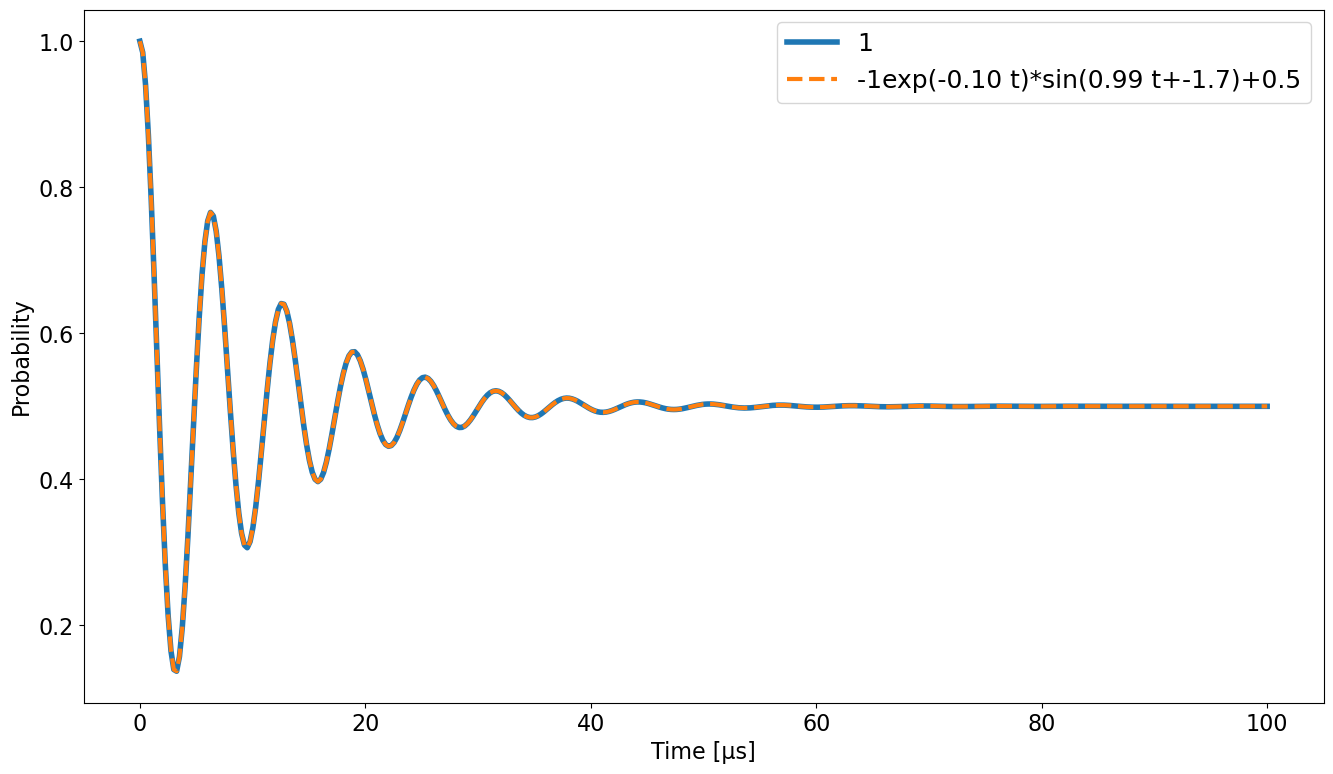

In [301]:
fig, ax = plt.subplots(figsize=(16,9))
# probs = np.abs(Mresults.states) ** 2
tempStates = []
RY = ry(np.pi/2)
for state in Mresults.states:
    tempStates.append(RY*state*RY.dag())
m = Qobj([[0,0],[0,1]])*tempStates
probs=[]
for state in m:
    probs.append((state[0,0]+state[1,1]))
# ax.plot(result.times, probs[:,0], label="0")
pop, pcov = curve_fit(dampedSineFit, Mresults.times, probs, [0.5,-0.1,10/20, 0, 0.5])
ax.plot(Mresults.times, probs, label="1", linewidth=4)
ax.plot(Mresults.times, dampedSineFit(Mresults.times, *pop), "--", label=f"{pop[0]:0.0f}exp({pop[1]:0.2f} t)*sin({pop[2]:0.2f} t+{pop[3]:0.1f})+{pop[4]:0.1f}", linewidth=3)
# ax.plot(Mresults.times, expFit(Mresults.times, *[1,-0.01,0.25]), "--")
# ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")

ax.set_xlabel("Time [μs]")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

In [295]:
print(pop)

[-0.27387286 -0.03546636  0.50257809 -0.13095287  0.53864819]


In [243]:
sphere = Bloch()
sphere.render()
print(sphere.axes, sphere.fig)

def animate(i):
    sphere.clear()
    sphere.add_states(Mresults.states[i])
    sphere.render()
    return sphere.axes

def init():
    sphere.vector_color = ["r"]
    return sphere.axes

# sphere.clear()
# sphere.add_states(result.states[0])
# sphere.render()
ani = animation.FuncAnimation(sphere.fig, animate, len(Mresults.times), init_func=init, blit=False, repeat=False)
writer = animation.PillowWriter(fps=30, bitrate=1800)
ani.save('T1_BlochSphere.gif', writer=writer)

Axes3D(0,0;1x1) Figure(500x500)


In [224]:
Mresults.states

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.5 0.5]
  [0.5 0.5]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.5       +0.j         0.44070176+0.22824197j]
  [0.44070176-0.22824197j 0.5       +0.j        ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.5       +0.j         0.28424717+0.38150883j]
  [0.28424717-0.38150883j 0.5       +0.j        ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.5       +0.j         0.07638353+0.43118682j]
  [0.07638353-0.43118682j 0.5       +0.j        ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 0.5       +0.j        -0.12950536+0.3755512j]
  [-0.12950536-0.3755512j  0.5       +0.j       ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 0.5       

In [233]:
ry(np.pi/2)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

In [251]:
hs2 = 1/np.sqrt(2)
RY*Qobj([[hs2, hs2], [hs2, hs2]])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 0.]
 [1. 1.]]

In [252]:
HD()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

In [253]:
RY

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

In [259]:
psi = HD()*basis(2,0)
rho = psi*psi.dag()
RY * rho

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.         0.        ]
 [0.70710678 0.70710678]]

In [260]:
zero = basis(2,0)

In [264]:
s = RY*(zero*zero.dag())

In [265]:
s.isket

False

In [285]:
b = Bloch()
b.add_states(tempStates[0])
b.make_sphere()

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

In [269]:
s

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.70710678 0.        ]
 [0.70710678 0.        ]]

In [276]:
p = np.sqrt(np.abs(probs))

In [277]:
p

array([0.84089642, 0.83754154, 0.82727876, 0.80985434, 0.78507714,
       0.75280974, 0.71294333, 0.66535738, 0.6098706 , 0.54622208,
       0.47430024, 0.39591471, 0.32574174, 0.31679963, 0.37459281,
       0.44245578, 0.50289358, 0.55446575, 0.59808699, 0.6347485 ,
       0.66519761, 0.68993422, 0.70925804, 0.7233206 , 0.73217407,
       0.73581493, 0.73422246, 0.72739162, 0.71536174, 0.69824386,
       0.67625177, 0.64974686, 0.61931415, 0.58590023, 0.55105866,
       0.5173343 , 0.48865008, 0.47002667, 0.46555094, 0.47542269,
       0.49575719, 0.52150427, 0.5487412 , 0.57505811, 0.59912529,
       0.62023935, 0.6380303 , 0.65230027, 0.66294224, 0.66990352,
       0.67317378, 0.67278676, 0.66882982, 0.66145875, 0.65091725,
       0.63756166, 0.62189206, 0.60458957, 0.58655516, 0.56893448,
       0.55309432, 0.54049946, 0.53245348, 0.52975325, 0.5324284 ,
       0.53974615, 0.55048196, 0.56327367, 0.57688172, 0.59030459,
       0.60279008, 0.61379896, 0.62295849, 0.6300226 , 0.63484

In [286]:
Mresults.states[0]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]

In [288]:
RY*zero*(RY*zero).dag()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]

In [289]:
zero*zero.dag()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [290]:
RY*(zero*zero.dag())*RY.dag()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]